In [2]:
# import all necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from numpy import dot
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from datasets import load_dataset
import pandas as pd

/home2/autotune_vits/miniconda3/envs/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 2080 Ti


## Data Preprocessing

In [4]:
def get_sentences(csv_file):
    df = pd.read_csv(csv_file, nrows=20000)
    # Drop NaN values from 'output' and 'input' columns
    train_sentences = df['output'].dropna().tolist()
    test_sentences = df['input'].dropna().tolist()
    return train_sentences, test_sentences

In [5]:
sentences, test_sentences = get_sentences('C4_200M_1M.csv')

In [6]:
print(len(sentences))
print(sentences[:10])

20000
['Bitcoin goes for $7,094 this morning, according to CoinDesk.', '1. The effect of "widespread dud" targets two face up attack position monsters on the field.', 'Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law.', 'Many brands and sellers still in the market.', 'This is is the latest maintenance release of Samba 3.6.', "Fairy Or Not, I'm the Godmother: Not just a look, but my outfit for taking on the role as godmother.", 'Watch as this Dodge Challenger Hellcat gets smoked by a Tesla Model S at the drag strip.', 'Moreover, these devices are proven to help consumers while another company that information.', 'Every cloud has a silver lining and it’s just possible that we were beaten

In [7]:
class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences
        self.stop_words = set(stopwords.words('english'))

    def word_tokenizer(self):
        # Define unique placeholders for special tokens
        placeholders = {
            '<URL>': 'URL_PLACEHOLDER',
            '<MAILID>': 'MAILID_PLACEHOLDER',
            '<HASHTAG>': 'HASHTAG_PLACEHOLDER',
            '<MENTION>': 'MENTION_PLACEHOLDER',
            '<PERCENT>': 'PERCENT_PLACEHOLDER',
            '<AGE>': 'AGE_PLACEHOLDER',
            '<TIME>': 'TIME_PLACEHOLDER',
            '<NUM>': 'NUM_PLACEHOLDER'
        }

        # Replace special tokens with placeholders
        for key, value in placeholders.items():
            self.sentences = [sentence.replace(key, value) for sentence in self.sentences]

        # Tokenize sentences
        self.sentences = [word_tokenize(sentence) for sentence in self.sentences]

        # Replace placeholders with original special tokens
        for key, value in placeholders.items():
            self.sentences = [[token if token != value else key for token in sentence] for sentence in self.sentences]

        return self.sentences

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]
    
    def remove_stop_words(self):
        stop_words = self.stop_words
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def remove_punctuation(self):
        # Define a set of basic punctuation characters to remove
        basic_punctuation = {'.', ',', ';', ':', '!', '-', '(', ')', '[', ']', '{', '}', '"', "'"}
        self.sentences = [[word for word in sentence if word not in basic_punctuation] for sentence in self.sentences]

    # identify numbers and replace them with a special token <NUM>
    def replace_numbers(self):
        number_regex = r'\b\d+\b'  # Regular expression to match whole numbers
        self.sentences = [re.sub(number_regex, '<NUM>', sentence) for sentence in self.sentences]
    
    def replace_urls(self):
        url_regex = r'\b(?:https?://|www\.)\S+\b'
        self.sentences = [re.sub(url_regex, '<URL>', sentence) for sentence in self.sentences]
    
    def replace_emails(self):
        email_regex = r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b'
        self.sentences = [re.sub(email_regex, '<MAILID>', sentence, flags=re.IGNORECASE) for sentence in self.sentences]
        
    def replace_hashtags(self):
        hashtag_regex = r'\#\w+'
        self.sentences = [re.sub(hashtag_regex, '<HASHTAG>', sentence, flags=re.IGNORECASE) for sentence in self.sentences]
    
    def replace_mentions(self):
        mention_regex = r'\@\w+'
        self.sentences = [re.sub(mention_regex, '<MENTION>', sentence, flags=re.IGNORECASE) for sentence in self.sentences]
    
    def replace_percentages(self):
        percent_regex = r'\b\d+(\.\d+)?%|\b\d+(\.\d+)?\s?(percent|per cent|percentage)\b'
        self.sentences = [re.sub(percent_regex, '<PERCENT>', sentence, flags=re.IGNORECASE) for sentence in self.sentences]
    
    def replace_age_values(self):
        age_regex = r'\b\d+-year-old|\b\d+\syear(s)?\sold\b'
        self.sentences = [re.sub(age_regex, '<AGE>', sentence, flags=re.IGNORECASE) for sentence in self.sentences]
    
    def replace_time_expressions(self):
        time_regex = r'\b\d{1,2}:\d{2}\s?(AM|PM|am|pm)\b'
        self.sentences = [re.sub(time_regex, '<TIME>', sentence) for sentence in self.sentences]
    
    def replace_backslashes(self):
        backslash_regex = r'\\'
        self.sentences = [re.sub(backslash_regex, '', sentence) for sentence in self.sentences]
        backtick_regex = r'`'
        self.sentences = [re.sub(backtick_regex, '', sentence) for sentence in self.sentences]
        self.sentences = [sentence.replace("''", '') for sentence in self.sentences]
        # Regular expression to find quoted text (simple version)
        quotes_regex = r'\"[^\"]*\"'
        self.sentences = [re.sub(quotes_regex, lambda m: m.group(0)[1:-1], sentence) for sentence in self.sentences]
    
    def process(self):
        self.replace_backslashes()
        # self.replace_urls()
        # self.replace_emails()
        # self.replace_hashtags()
        # self.replace_mentions()

        self.replace_percentages()
        self.replace_age_values()
        self.replace_time_expressions()
        self.replace_numbers()

        self.word_tokenizer()

        self.lowercase()
        self.remove_stop_words()
        self.remove_punctuation()
        
        return self.sentences


In [8]:
# Preprocess the sentences
preprocess = Preprocess(sentences)
sentences = preprocess.process()

In [27]:
# Preprocess the test sentences
preprocess = Preprocess(test_sentences)
test_sentences = preprocess.process()

In [9]:
print(len(sentences))
print(sentences[:10])

20000
[['bitcoin', 'goes', '$', '<num>', '<num>', 'morning', 'according', 'coindesk'], ['<num>', 'effect', 'widespread', 'dud', 'targets', 'two', 'face', 'attack', 'position', 'monsters', 'field'], ['capital', 'gains', 'tax', 'sale', 'properties', 'non-residents', 'set', '<percent>', '<num>', '<percent>', '<num>', 'payable', 'profits', 'earned', 'difference', 'property', 'value', 'year', 'purchase', 'purchase', 'price', 'plus', 'costs', 'year', 'sale', 'sales', 'price', 'minus', 'costs', 'based', 'approved', 'annual', 'percentage', 'increase', 'base', 'value', 'approved', 'law'], ['many', 'brands', 'sellers', 'still', 'market'], ['latest', 'maintenance', 'release', 'samba', 'num_placeholder.num_placeholder'], ['fairy', "'m", 'godmother', 'look', 'outfit', 'taking', 'role', 'godmother'], ['watch', 'dodge', 'challenger', 'hellcat', 'gets', 'smoked', 'tesla', 'model', 'drag', 'strip'], ['moreover', 'devices', 'proven', 'help', 'consumers', 'another', 'company', 'information'], ['every', '

In [10]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        # Initialize vocab with special tokens
        self.itos = {0: "<PAD>", 1: "<UNK>", 2: "<BOS>", 3: "<EOS>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter(word for sentence in sentence_list for word in sentence)
        idx = len(self.itos)  # Start indexing for new words from here
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in text]

In [16]:
# Create vocabulary object
vocab = Vocabulary(freq_threshold=3)
vocab.build_vocabulary(sentences)

In [17]:
# Check the length of the vocabulary
print(len(vocab))
# Print some of the tokens in the vocabulary
print(list(vocab.stoi.items())[:10])

12344
[('<PAD>', 0), ('<UNK>', 1), ('<BOS>', 2), ('<EOS>', 3), ('bitcoin', 4), ('goes', 5), ('$', 6), ('<num>', 7), ('morning', 8), ('according', 9)]


In [18]:
def create_dataloader(sentences, vocab, sequence_length=50, batch_size=64):
    # Initialize lists to hold numericalized sentences (X) and targets (y)
    X = []
    y = []

    for sentence in sentences:
        # Numericalize the sentence
        numericalized = [vocab.stoi["<BOS>"]] + vocab.numericalize(sentence) + [vocab.stoi["<EOS>"]]
        # Pad or truncate the sentence to the desired sequence length
        padded = numericalized[:sequence_length] + [vocab.stoi["<PAD>"]] * max(0, sequence_length - len(numericalized))
        if len(padded) > sequence_length:
            padded = padded[:sequence_length-1] + [vocab.stoi["<EOS>"]]
        
        # Append to lists
        X.append(padded[:-1])  # Input sequence
        y.append(padded[1:])   # Target sequence (next word prediction)
    
    # Convert lists to tensors
    X_tensor = torch.tensor(X, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

In [19]:
# Create a dataloader
train_dataloader = create_dataloader(sentences, vocab, sequence_length=50, batch_size=32)

## LSTM Model

In [20]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Embedding dropout
        self.embedding_dropout = nn.Dropout(dropout)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        
        # Dropout layer before the fully connected layer
        self.fc_dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, text):
        embedded = self.embedding_dropout(self.embedding(text))
        lstm_out, _ = self.lstm(embedded)
        
        # Apply dropout to the outputs of the LSTM layer before passing to the fully connected layer
        out = self.fc(self.fc_dropout(lstm_out))
        return out

In [21]:
# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 64
num_layers = 2
dropout = 0.2

learning_rate = 0.001
num_epochs = 10

# Initialize the model
model = BiLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
def train_lstm(model, train_dataloader, optimizer, criterion, device, num_epochs):
    model.to(device)  # Ensure the model is on the correct device
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.shape[-1])  # Reshape for calculating loss
            targets = targets.view(-1)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

In [23]:
train_lstm(model, train_dataloader, optimizer, criterion, device, num_epochs)

Epoch 1/10, Loss: 6.7114
Epoch 2/10, Loss: 5.4577
Epoch 3/10, Loss: 4.3440
Epoch 4/10, Loss: 3.4829
Epoch 5/10, Loss: 2.8250
Epoch 6/10, Loss: 2.3211
Epoch 7/10, Loss: 1.9257
Epoch 8/10, Loss: 1.6016
Epoch 9/10, Loss: 1.3405
Epoch 10/10, Loss: 1.1243


## Perplexity

In [24]:
# Function to calculate perplexity
def sentence_perplexity(preprocessed_tokens, model, vocab, device):
    # Ensure the sentence starts with <BOS> and ends with <EOS>
    tokens = ['<BOS>'] + preprocessed_tokens + ['<EOS>']
    
    # Numericalize the tokens
    numericalized_tokens = [vocab.stoi.get(token, vocab.stoi['<UNK>']) for token in tokens]
    
    # Convert to a tensor and add a batch dimension
    input_tensor = torch.LongTensor(numericalized_tokens).unsqueeze(0).to(device)
    
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=2)
        
        target_probabilities = probabilities[0, range(len(numericalized_tokens)-1), numericalized_tokens[1:]]
        
        log_probabilities = torch.log2(target_probabilities)
        
        # Calculate perplexity
        perplexity = torch.pow(2, -log_probabilities.mean())

    return perplexity.item()

In [32]:
def average_and_median_perplexity(sentences, model, vocab, device):
    perplexities = [sentence_perplexity(sentence, model, vocab, device) for sentence in sentences]
    
    average_perplexity = sum(perplexities) / len(perplexities)
    median_perplexity = np.median(perplexities)
    
    return average_perplexity, median_perplexity

In [29]:
# Function to plot perplexity distribution
def plot_perplexity_distribution(sentences, model, vocab, device):
    perplexities = []
    
    for sentence in sentences:
        perplexity = sentence_perplexity(sentence, model, vocab, device)
        perplexities.append(perplexity)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(perplexities, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Sentence Perplexities')
    plt.xlabel('Perplexity')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [33]:
# Get the average perplexity of the training sentences
train_avg, train_med = average_and_median_perplexity(sentences, model, vocab, device) 
print(f'Training Average Perplexity: {train_avg:.4f}')
print(f'Training Median Perplexity: {train_med:.4f}')

Training Average Perplexity: 1.7059
Training Median Perplexity: 1.5108


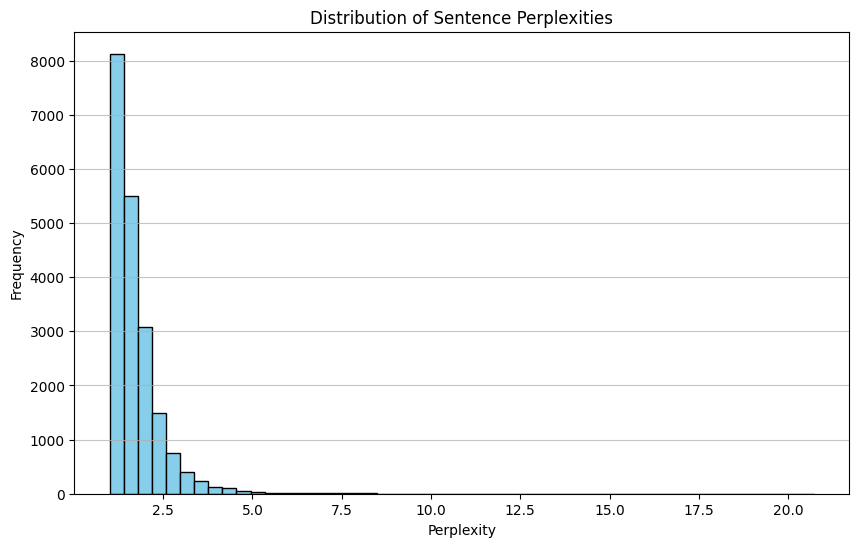

In [30]:
# Plot the perplexity distribution of the training sentences
plot_perplexity_distribution(sentences, model, vocab, device)

In [34]:
# Get the average perplexity of the test sentences
test_avg, test_med = average_and_median_perplexity(test_sentences, model, vocab, device)
print(f'Test Average Perplexity: {test_avg:.4f}')
print(f'Test Median Perplexity: {test_med:.4f}')

Test Average Perplexity: 1.6833
Test Median Perplexity: 1.4858


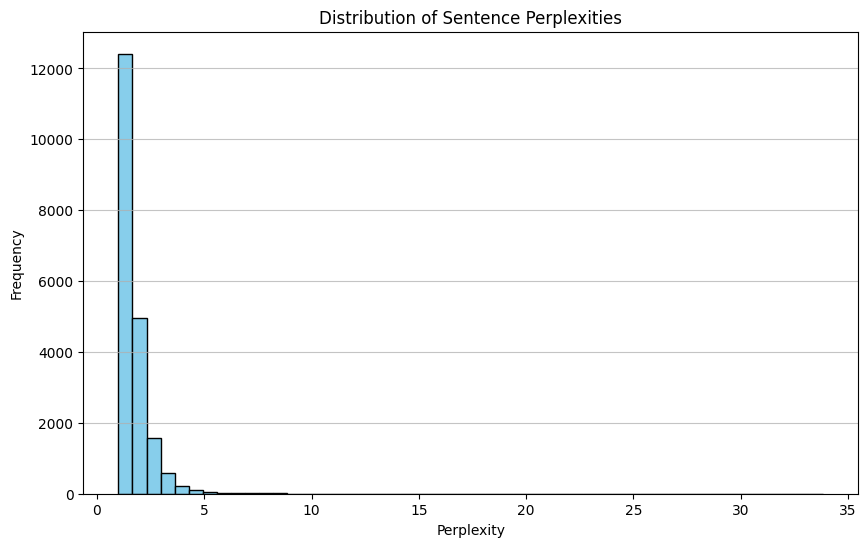

In [31]:
# Plot the perplexity distribution of the test sentences
plot_perplexity_distribution(test_sentences, model, vocab, device)